In [19]:
import polars as pl
import polars.selectors as cs
import soccerdata as sd
import matplotlib.pyplot as plt
import sklearn as skl
import pandas as ps
import numpy as np
import pyarrow
import seaborn as sb

In [20]:
fbref = sd.FBref(seasons = "2025-26")

[12/20/25 13:36:15] INFO     Saving cached data to C:\Users\User\soccerdata\data\FBref               ]8;id=16461;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=514891;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

In [21]:
s = fbref.read_player_season_stats(stat_type="standard")
s1 = pl.from_pandas(s, include_index=True)
s1 = s1.filter(
    (pl.col("('born', '')") >= 1999))
progress = fbref.read_player_season_stats(stat_type="possession")
p1 = pl.from_pandas(progress, include_index=True)
passes = fbref.read_player_season_stats(stat_type="passing")
p2 = pl.from_pandas(passes, include_index=True)
creative = fbref.read_player_season_stats(stat_type="goal_shot_creation")
c1 = pl.from_pandas(creative, include_index=True)
defense = fbref.read_player_season_stats(stat_type="defense")
d1 = pl.from_pandas(defense, include_index=True)

S = s1.drop("season")
S = S.drop("('nation', '')")
S = S.drop("('born', '')")
S = S.drop("('age', '')")

S = S.drop([
    "('Playing Time', 'MP')",     
    "('Playing Time', 'Starts')",
    "('Playing Time', 'Min')"
])

D = d1.drop("season")
D = D.drop("('nation', '')")
D = D.drop("('born', '')")
D = D.drop("('age', '')")
D = D.drop("('90s', '')")

C = c1.drop("season")
C = C.drop("('nation', '')")
C = C.drop("('born', '')")
C = C.drop("('age', '')")
C = C.drop("('90s', '')")
C = C.drop("('SCA', 'SCA90')")
C = C.drop("('GCA', 'GCA90')")

P = p1.drop("season")
P = P.drop("('nation', '')")
P = P.drop("('born', '')")
P = P.drop("('age', '')")
P = P.drop("('90s', '')")

P2 = p2.drop("season")
P2 = P2.drop("('nation', '')")
P2 = P2.drop("('born', '')")
P2 = P2.drop("('age', '')")
P2 = P2.drop("('90s', '')")

all_player = S.join(P, on=["league", "team", "player"], how="inner", suffix="_progress")
all_player = all_player.join(C, on=["league", "team", "player"], how="inner", suffix="_creative")
all_player = all_player.join(D, on=["league", "team", "player"], how="inner", suffix="_defense")
all_player = all_player.join(P2, on=["league", "team", "player"], how="inner", suffix="_passes")
all_player = all_player.filter(
    (pl.col("('pos', '')").str.contains("MF")) |
    (pl.col("('pos', '')").str.contains("FW"))
)
all_player = all_player.drop("('pos', '')")     
all_player = all_player.drop(cs.matches(r"^\('Per 90 Minutes'.*"))
all_player = all_player.fill_nan(0.0)


[12/20/25 13:36:16] WARNING  C:\Users\User\anaconda3\envs\fbrefshit\Lib\site-packages\soccerdata\fb ]8;id=497543;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\warnings.py\warnings.py]8;;\:]8;id=763612;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\warnings.py#112\112]8;;\
                             ref.py:165: FutureWarning: The behavior of DataFrame concatenation                    
                             with empty or all-NA entries is deprecated. In a future version, this                 
                             will no longer exclude empty or all-NA columns when determining the                   
                             result dtypes. To retain the old behavior, exclude the relevant                       
                             entries before the concat operation.                                                  
                               pd.concat(dfs)                                                                      
                                                                                                                   

[12/20/25 13:36:18] WARNING  C:\Users\User\anaconda3\envs\fbrefshit\Lib\site-packages\soccerdata\_c ]8;id=87317;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\warnings.py\warnings.py]8;;\:]8;id=567168;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\warnings.py#112\112]8;;\
                             ommon.py:145: UserWarning: Season id "2021" is ambiguous: interpreting                
                             as "20-21"                                                                            
                               warnings.warn(msg, stacklevel=1)                                                    
                                                                                                                   

[12/20/25 13:36:22] WARNING  C:\Users\User\anaconda3\envs\fbrefshit\Lib\site-packages\soccerdata\fb ]8;id=319218;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\warnings.py\warnings.py]8;;\:]8;id=740844;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\warnings.py#112\112]8;;\
                             ref.py:165: FutureWarning: The behavior of DataFrame concatenation                    
                             with empty or all-NA entries is deprecated. In a future version, this                 
                             will no longer exclude empty or all-NA columns when determining the                   
                             result dtypes. To retain the old behavior, exclude the relevant                       
                             entries before the concat operation.                                                  
                               pd.concat(dfs)                                                                      
                                                                                                                   

[12/20/25 13:36:23] WARNING  C:\Users\User\anaconda3\envs\fbrefshit\Lib\site-packages\soccerdata\_c ]8;id=110542;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\warnings.py\warnings.py]8;;\:]8;id=773399;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\warnings.py#112\112]8;;\
                             ommon.py:145: UserWarning: Season id "2021" is ambiguous: interpreting                
                             as "20-21"                                                                            
                               warnings.warn(msg, stacklevel=1)                                                    
                                                                                                                   

[12/20/25 13:36:26] WARNING  C:\Users\User\anaconda3\envs\fbrefshit\Lib\site-packages\soccerdata\fb ]8;id=638302;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\warnings.py\warnings.py]8;;\:]8;id=331303;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\warnings.py#112\112]8;;\
                             ref.py:165: FutureWarning: The behavior of DataFrame concatenation                    
                             with empty or all-NA entries is deprecated. In a future version, this                 
                             will no longer exclude empty or all-NA columns when determining the                   
                             result dtypes. To retain the old behavior, exclude the relevant                       
                             entries before the concat operation.                                                  
                               pd.concat(dfs)                                                                      
                                                                                                                   

[12/20/25 13:36:27] WARNING  C:\Users\User\anaconda3\envs\fbrefshit\Lib\site-packages\soccerdata\_c ]8;id=285059;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\warnings.py\warnings.py]8;;\:]8;id=76154;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\warnings.py#112\112]8;;\
                             ommon.py:145: UserWarning: Season id "2021" is ambiguous: interpreting                
                             as "20-21"                                                                            
                               warnings.warn(msg, stacklevel=1)                                                    
                                                                                                                   

[12/20/25 13:36:30] WARNING  C:\Users\User\anaconda3\envs\fbrefshit\Lib\site-packages\soccerdata\fb ]8;id=39020;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\warnings.py\warnings.py]8;;\:]8;id=86617;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\warnings.py#112\112]8;;\
                             ref.py:165: FutureWarning: The behavior of DataFrame concatenation                    
                             with empty or all-NA entries is deprecated. In a future version, this                 
                             will no longer exclude empty or all-NA columns when determining the                   
                             result dtypes. To retain the old behavior, exclude the relevant                       
                             entries before the concat operation.                                                  
                               pd.concat(dfs)                                                                      
                                                                                                                   

                    WARNING  C:\Users\User\anaconda3\envs\fbrefshit\Lib\site-packages\soccerdata\_c ]8;id=989764;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\warnings.py\warnings.py]8;;\:]8;id=529909;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\warnings.py#112\112]8;;\
                             ommon.py:145: UserWarning: Season id "2021" is ambiguous: interpreting                
                             as "20-21"                                                                            
                               warnings.warn(msg, stacklevel=1)                                                    
                                                                                                                   

[12/20/25 13:36:34] WARNING  C:\Users\User\anaconda3\envs\fbrefshit\Lib\site-packages\soccerdata\fb ]8;id=467426;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\warnings.py\warnings.py]8;;\:]8;id=980717;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\warnings.py#112\112]8;;\
                             ref.py:165: FutureWarning: The behavior of DataFrame concatenation                    
                             with empty or all-NA entries is deprecated. In a future version, this                 
                             will no longer exclude empty or all-NA columns when determining the                   
                             result dtypes. To retain the old behavior, exclude the relevant                       
                             entries before the concat operation.                                                  
                               pd.concat(dfs)                                                                      
                                                                                                                   

                    WARNING  C:\Users\User\anaconda3\envs\fbrefshit\Lib\site-packages\soccerdata\_c ]8;id=591935;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\warnings.py\warnings.py]8;;\:]8;id=166767;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\warnings.py#112\112]8;;\
                             ommon.py:145: UserWarning: Season id "2021" is ambiguous: interpreting                
                             as "20-21"                                                                            
                               warnings.warn(msg, stacklevel=1)                                                    
                                                                                                                   

In [22]:
exclude_cols = ["born", "season", "league", "team", "player"]

numeric_cols_all = all_player.select(cs.numeric().exclude(exclude_cols)).columns

cols_to_normalize = [
    c for c in numeric_cols_all 
    if "90s" not in c 
    and "%" not in c 
    and "Pct" not in c
]

all_player = all_player.with_columns([
    (pl.col(col_name) / pl.col("('Playing Time', '90s')")).alias(col_name)
    for col_name in cols_to_normalize
])

all_player = all_player.fill_nan(0.0).fill_null(0.0).with_columns([
    pl.when(pl.col(col_name).is_infinite())
      .then(0.0)
      .otherwise(pl.col(col_name))
      .alias(col_name)
    for col_name in numeric_cols_all
])

In [23]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

identifier_cols = ["league", "team", "player"]
numeric_data = all_player.select(pl.col(pl.Float64, pl.Int64))

X_filtered = numeric_data.fill_null(0).to_numpy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_filtered)

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_scaled)
labels = kmeans.labels_

all_players_with_clusters = all_player. with_columns(
    pl.Series(name="cluster", values=labels)
)

new = all_players_with_clusters.select(["player", "team", "cluster"]).filter(pl.col("player") == "Amad Diallo")
num = new.get_column("cluster")
target = all_players_with_clusters.filter(pl.col("cluster") == num)

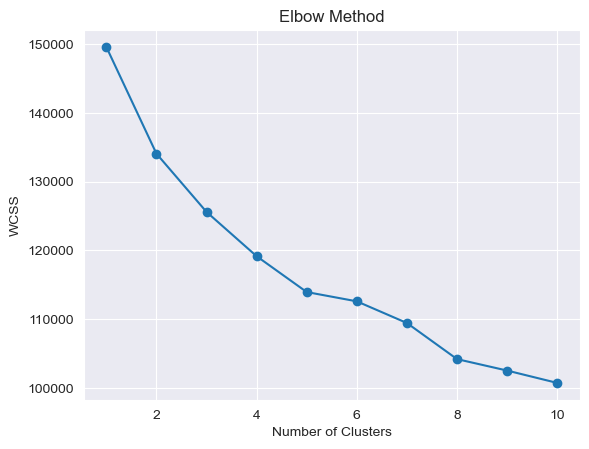

In [24]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

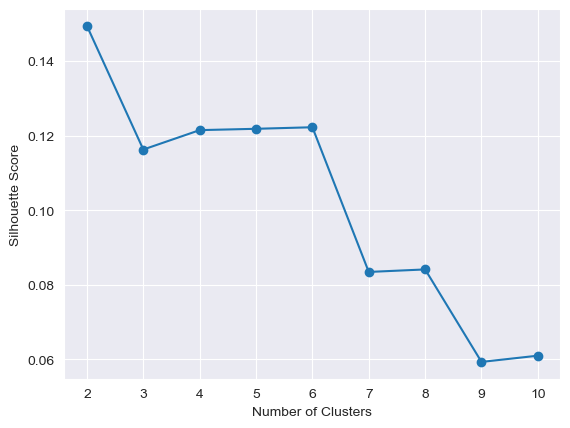

In [25]:
from sklearn.metrics import silhouette_score

scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    scores.append(silhouette_score(X_scaled, labels))

plt.plot(range(2, 11), scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

target_cluster_id = num
identifier_cols = ["league", "team", "player"]

WG_Profile = target[["league", "team", "player",
"('Expected', 'npxG+xAG')",
"('Take-Ons', 'Att')",
"('Take-Ons', 'Succ%')",
"('Carries', 'PrgC')",
"('Carries', 'TotDist')",
"('Carries', 'PrgDist')",
"('Carries', '1/3')",
"('Carries', 'CPA')",
"('Tackles', 'Tkl')",
"('Challenges', 'Tkl')",
"('Challenges', 'Att')",
"('Challenges', 'Tkl%')",
"('Int', '')",
"('SCA Types', 'TO')",
"('SCA Types', 'Sh')",
"('SCA Types', 'Fld')",
"('SCA Types', 'Def')",
"('SCA', 'SCA')",
"('GCA', 'GCA')"]]

nums = WG_Profile.select(pl.col(pl.Float64, pl.Int64))
print(f"Sub-clustering {WG_Profile.height} players from Cluster {target_cluster_id}...")

scaler_sub = StandardScaler()
X_sub_scaled = scaler_sub.fit_transform(nums)

kmeans_sub = KMeans(n_clusters=5, random_state=42)
sub_labels = kmeans_sub.fit_predict(X_sub_scaled)
sub_centroids = kmeans_sub.cluster_centers_  # 修正: kmeans → kmeans_sub

WG = WG_Profile.with_columns(
    pl.Series(name="sub_cluster", values=sub_labels)
)

Sub-clustering 637 players from Cluster shape: (1,)
Series: 'cluster' [i32]
[
	0
]...


[12/20/25 13:36:41] WARNING  C:\Users\User\anaconda3\envs\fbrefshit\Lib\site-packages\sklearn\clust ]8;id=954149;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\warnings.py\warnings.py]8;;\:]8;id=594200;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\warnings.py#112\112]8;;\
                             er\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak                
                             on Windows with MKL, when there are less chunks than available                        
                             threads. You can avoid it by setting the environment variable                         
                             OMP_NUM_THREADS=3.                                                                    
                               warnings.warn(                                                                      
                                                                                                                   

In [27]:
WG

league,team,player,"('Expected', 'npxG+xAG')","('Take-Ons', 'Att')","('Take-Ons', 'Succ%')","('Carries', 'PrgC')","('Carries', 'TotDist')","('Carries', 'PrgDist')","('Carries', '1/3')","('Carries', 'CPA')","('Tackles', 'Tkl')","('Challenges', 'Tkl')","('Challenges', 'Att')","('Challenges', 'Tkl%')","('Int', '')","('SCA Types', 'TO')","('SCA Types', 'Sh')","('SCA Types', 'Fld')","('SCA Types', 'Def')","('SCA', 'SCA')","('GCA', 'GCA')",sub_cluster
str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i32
"""ENG-EFL Championship""","""Birmingham City""","""Marc Leonard""",0.109091,0.363636,50.0,1.454545,196.0,97.818182,0.909091,0.0,4.363636,2.727273,4.363636,62.5,1.272727,0.0,0.181818,0.181818,0.181818,3.090909,0.181818,1
"""ENG-EFL Championship""","""Birmingham City""","""Tommy Doyle""",0.19685,0.629921,62.5,0.314961,178.188976,57.165354,0.866142,0.0,1.574803,0.629921,1.023622,61.5,0.944882,0.07874,0.07874,0.15748,0.07874,4.409449,0.472441,1
"""ENG-EFL Championship""","""Blackburn""","""Moussa Baradji""",0.125,3.75,33.3,2.5,175.0,66.25,3.75,1.25,6.25,1.25,1.25,100.0,0.0,0.0,0.0,0.0,0.0,1.25,0.0,1
"""ENG-EFL Championship""","""Blackburn""","""Taylor Gardner-Hickman""",0.166667,0.877193,40.0,1.140351,100.087719,46.22807,0.789474,0.087719,2.105263,0.877193,2.54386,34.5,1.315789,0.0,0.087719,0.087719,0.087719,3.070175,0.175439,1
"""ENG-EFL Championship""","""Bristol City""","""Adam Randell""",0.08,0.7,35.7,0.95,107.15,57.45,0.65,0.0,1.45,0.65,1.25,52.0,0.85,0.05,0.15,0.25,0.1,2.8,0.15,1
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Por-Primeira Liga""","""Tondela""","""Tiago Manso""",0.083333,2.083333,55.0,1.25,137.083333,73.958333,1.041667,0.208333,2.395833,1.770833,3.75,47.2,1.145833,0.208333,0.208333,0.3125,0.0,1.979167,0.0,1
"""Por-Primeira Liga""","""Vitória""","""Beni""",0.091837,2.653061,53.8,1.22449,165.102041,68.265306,1.428571,0.102041,2.55102,1.530612,1.938776,78.9,1.22449,0.204082,0.0,0.102041,0.0,1.938776,0.0,1
"""Por-Primeira Liga""","""Vitória""","""Gonçalo Nogueira""",0.179487,2.820513,54.5,1.538462,142.051282,61.794872,1.794872,0.0,2.307692,1.538462,2.051282,75.0,1.025641,0.0,0.25641,0.512821,0.512821,3.333333,0.512821,1


[12/20/25 13:36:42] WARNING  C:\Users\User\anaconda3\envs\fbrefshit\Lib\site-packages\sklearn\clust ]8;id=752203;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\warnings.py\warnings.py]8;;\:]8;id=574651;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\warnings.py#112\112]8;;\
                             er\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak                
                             on Windows with MKL, when there are less chunks than available                        
                             threads. You can avoid it by setting the environment variable                         
                             OMP_NUM_THREADS=3.                                                                    
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\Users\User\anaconda3\envs\fbrefshit\Lib\site-packages\sklearn\clust ]8;id=778258;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\warnings.py\warnings.py]8;;\:]8;id=979600;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\warnings.py#112\112]8;;\
                             er\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak                
                             on Windows with MKL, when there are less chunks than available                        
                             threads. You can avoid it by setting the environment variable                         
                             OMP_NUM_THREADS=3.                                                                    
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\Users\User\anaconda3\envs\fbrefshit\Lib\site-packages\sklearn\clust ]8;id=809335;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\warnings.py\warnings.py]8;;\:]8;id=289946;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\warnings.py#112\112]8;;\
                             er\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak                
                             on Windows with MKL, when there are less chunks than available                        
                             threads. You can avoid it by setting the environment variable                         
                             OMP_NUM_THREADS=3.                                                                    
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\Users\User\anaconda3\envs\fbrefshit\Lib\site-packages\sklearn\clust ]8;id=38706;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\warnings.py\warnings.py]8;;\:]8;id=909339;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\warnings.py#112\112]8;;\
                             er\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak                
                             on Windows with MKL, when there are less chunks than available                        
                             threads. You can avoid it by setting the environment variable                         
                             OMP_NUM_THREADS=3.                                                                    
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\Users\User\anaconda3\envs\fbrefshit\Lib\site-packages\sklearn\clust ]8;id=232845;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\warnings.py\warnings.py]8;;\:]8;id=258423;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\warnings.py#112\112]8;;\
                             er\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak                
                             on Windows with MKL, when there are less chunks than available                        
                             threads. You can avoid it by setting the environment variable                         
                             OMP_NUM_THREADS=3.                                                                    
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\Users\User\anaconda3\envs\fbrefshit\Lib\site-packages\sklearn\clust ]8;id=302132;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\warnings.py\warnings.py]8;;\:]8;id=84944;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\warnings.py#112\112]8;;\
                             er\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak                
                             on Windows with MKL, when there are less chunks than available                        
                             threads. You can avoid it by setting the environment variable                         
                             OMP_NUM_THREADS=3.                                                                    
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\Users\User\anaconda3\envs\fbrefshit\Lib\site-packages\sklearn\clust ]8;id=471355;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\warnings.py\warnings.py]8;;\:]8;id=229284;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\warnings.py#112\112]8;;\
                             er\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak                
                             on Windows with MKL, when there are less chunks than available                        
                             threads. You can avoid it by setting the environment variable                         
                             OMP_NUM_THREADS=3.                                                                    
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\Users\User\anaconda3\envs\fbrefshit\Lib\site-packages\sklearn\clust ]8;id=163069;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\warnings.py\warnings.py]8;;\:]8;id=144296;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\warnings.py#112\112]8;;\
                             er\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak                
                             on Windows with MKL, when there are less chunks than available                        
                             threads. You can avoid it by setting the environment variable                         
                             OMP_NUM_THREADS=3.                                                                    
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\Users\User\anaconda3\envs\fbrefshit\Lib\site-packages\sklearn\clust ]8;id=536110;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\warnings.py\warnings.py]8;;\:]8;id=507109;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\warnings.py#112\112]8;;\
                             er\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak                
                             on Windows with MKL, when there are less chunks than available                        
                             threads. You can avoid it by setting the environment variable                         
                             OMP_NUM_THREADS=3.                                                                    
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\Users\User\anaconda3\envs\fbrefshit\Lib\site-packages\sklearn\clust ]8;id=103870;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\warnings.py\warnings.py]8;;\:]8;id=894227;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\warnings.py#112\112]8;;\
                             er\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak                
                             on Windows with MKL, when there are less chunks than available                        
                             threads. You can avoid it by setting the environment variable                         
                             OMP_NUM_THREADS=3.                                                                    
                               warnings.warn(                                                                      
                                                                                                                   

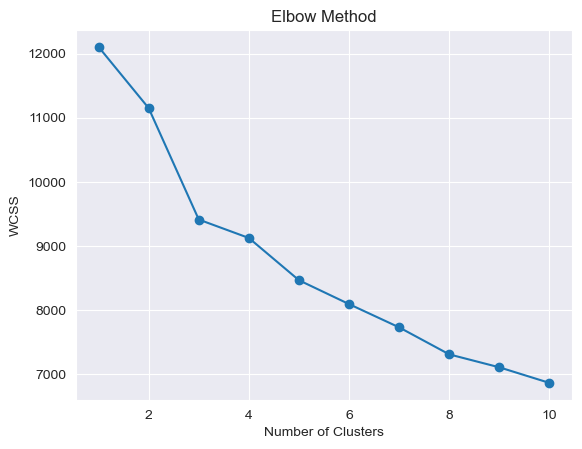

In [28]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_sub_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

                    WARNING  C:\Users\User\anaconda3\envs\fbrefshit\Lib\site-packages\sklearn\clust ]8;id=201780;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\warnings.py\warnings.py]8;;\:]8;id=969755;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\warnings.py#112\112]8;;\
                             er\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak                
                             on Windows with MKL, when there are less chunks than available                        
                             threads. You can avoid it by setting the environment variable                         
                             OMP_NUM_THREADS=3.                                                                    
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\Users\User\anaconda3\envs\fbrefshit\Lib\site-packages\sklearn\clust ]8;id=310187;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\warnings.py\warnings.py]8;;\:]8;id=374447;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\warnings.py#112\112]8;;\
                             er\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak                
                             on Windows with MKL, when there are less chunks than available                        
                             threads. You can avoid it by setting the environment variable                         
                             OMP_NUM_THREADS=3.                                                                    
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\Users\User\anaconda3\envs\fbrefshit\Lib\site-packages\sklearn\clust ]8;id=256821;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\warnings.py\warnings.py]8;;\:]8;id=149134;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\warnings.py#112\112]8;;\
                             er\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak                
                             on Windows with MKL, when there are less chunks than available                        
                             threads. You can avoid it by setting the environment variable                         
                             OMP_NUM_THREADS=3.                                                                    
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\Users\User\anaconda3\envs\fbrefshit\Lib\site-packages\sklearn\clust ]8;id=188111;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\warnings.py\warnings.py]8;;\:]8;id=918514;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\warnings.py#112\112]8;;\
                             er\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak                
                             on Windows with MKL, when there are less chunks than available                        
                             threads. You can avoid it by setting the environment variable                         
                             OMP_NUM_THREADS=3.                                                                    
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\Users\User\anaconda3\envs\fbrefshit\Lib\site-packages\sklearn\clust ]8;id=569363;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\warnings.py\warnings.py]8;;\:]8;id=640000;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\warnings.py#112\112]8;;\
                             er\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak                
                             on Windows with MKL, when there are less chunks than available                        
                             threads. You can avoid it by setting the environment variable                         
                             OMP_NUM_THREADS=3.                                                                    
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\Users\User\anaconda3\envs\fbrefshit\Lib\site-packages\sklearn\clust ]8;id=932868;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\warnings.py\warnings.py]8;;\:]8;id=928532;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\warnings.py#112\112]8;;\
                             er\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak                
                             on Windows with MKL, when there are less chunks than available                        
                             threads. You can avoid it by setting the environment variable                         
                             OMP_NUM_THREADS=3.                                                                    
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\Users\User\anaconda3\envs\fbrefshit\Lib\site-packages\sklearn\clust ]8;id=650378;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\warnings.py\warnings.py]8;;\:]8;id=568904;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\warnings.py#112\112]8;;\
                             er\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak                
                             on Windows with MKL, when there are less chunks than available                        
                             threads. You can avoid it by setting the environment variable                         
                             OMP_NUM_THREADS=3.                                                                    
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  C:\Users\User\anaconda3\envs\fbrefshit\Lib\site-packages\sklearn\clust ]8;id=972486;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\warnings.py\warnings.py]8;;\:]8;id=945641;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\warnings.py#112\112]8;;\
                             er\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak                
                             on Windows with MKL, when there are less chunks than available                        
                             threads. You can avoid it by setting the environment variable                         
                             OMP_NUM_THREADS=3.                                                                    
                               warnings.warn(                                                                      
                                                                                                                   

[12/20/25 13:36:43] WARNING  C:\Users\User\anaconda3\envs\fbrefshit\Lib\site-packages\sklearn\clust ]8;id=282228;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\warnings.py\warnings.py]8;;\:]8;id=609257;file://C:\Users\User\anaconda3\envs\fbrefshit\Lib\warnings.py#112\112]8;;\
                             er\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak                
                             on Windows with MKL, when there are less chunks than available                        
                             threads. You can avoid it by setting the environment variable                         
                             OMP_NUM_THREADS=3.                                                                    
                               warnings.warn(                                                                      
                                                                                                                   

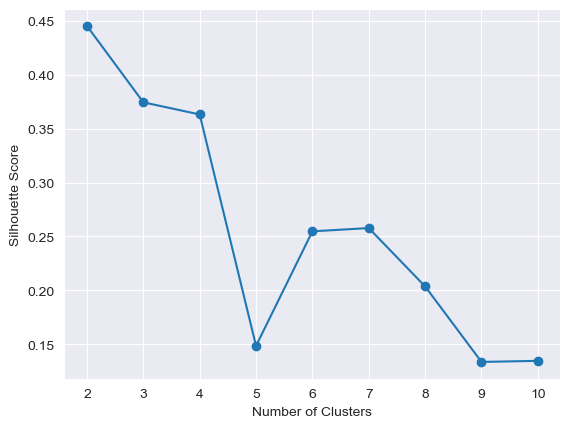

In [29]:
from sklearn.metrics import silhouette_score

scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_sub_scaled)
    scores.append(silhouette_score(X_sub_scaled, labels))

plt.plot(range(2, 11), scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [30]:
new = WG.select(["player", "team", "sub_cluster"]).filter(pl.col("player") == "Amad Diallo")
num = new.get_column("sub_cluster")
new
new2 = WG.select(["player", "team", "sub_cluster"]).filter(pl.col("sub_cluster") == num)
new2

player,team,sub_cluster
str,str,i32
"""Jack Rudoni""","""Coventry City""",0
"""Kai Andrews""","""Coventry City""",0
"""Kaine Kesler-Hayden""","""Coventry City""",0
"""Jens Cajuste""","""Ipswich Town""",0
"""Marcelino Núñez""","""Ipswich Town""",0
…,…,…
"""Ángel Alarcón""","""Porto""",0
"""Francisco Trincão""","""Sporting CP""",0
"""Geny Catamo""","""Sporting CP""",0


In [31]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

amad_idx = WG.with_row_index().filter(pl.col("player") == "Amad Diallo").select("index").item()

amad_scaled = X_sub_scaled[amad_idx].reshape(1, -1)

In [33]:
distances = pairwise_distances(X_sub_scaled, amad_scaled, metric='cosine')

X_closest = 20

closest_indices = np.argsort(distances[:, 0])[:X_closest]

print(f"Amad Diallo に最も近い上位 {X_closest} 人の選手:")
similar_players = WG[closest_indices].select(["player", "team"])
with pl.Config(tbl_rows=-1):
    print(similar_players)

Amad Diallo に最も近い上位 20 人の選手:
shape: (20, 2)
┌───────────────────────┬─────────────────┐
│ player                ┆ team            │
│ ---                   ┆ ---             │
│ str                   ┆ str             │
╞═══════════════════════╪═════════════════╡
│ Amad Diallo           ┆ Manchester Utd  │
│ Esmir Bajraktarevic   ┆ PSV Eindhoven   │
│ Vinicius Júnior       ┆ Real Madrid     │
│ Michael Olise         ┆ Bayern Munich   │
│ Lamine Yamal          ┆ Barcelona       │
│ Jeremy Doku           ┆ Manchester City │
│ Charles De Ketelaere  ┆ Atalanta        │
│ Khvicha Kvaratskhelia ┆ Paris S-G       │
│ Kenan Yıldız          ┆ Juventus        │
│ Michael Johnston      ┆ West Brom       │
│ Ro-Zangelo Daal       ┆ AZ Alkmaar      │
│ Rodrygo               ┆ Real Madrid     │
│ Mason Greenwood       ┆ Marseille       │
│ Bradley Barcola       ┆ Paris S-G       │
│ Alisson Santos        ┆ Sporting CP     │
│ Yan Diomandé          ┆ RB Leipzig      │
│ Francisco Conceição   ┆ Juvent